In [24]:
import tqdm
import rasterio as rio
import numpy as np
import pandas as pd
import os
import torch
import cv2
import matplotlib.pyplot as plt
from rasterio.plot import show


### Based heavily on code by Hanna et al. (2023) in dataset_multitask.py

TESTING ON: C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif AND C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\labels\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif:
Image has shape: (300, 300), (1, 300, 300)
Before cropping


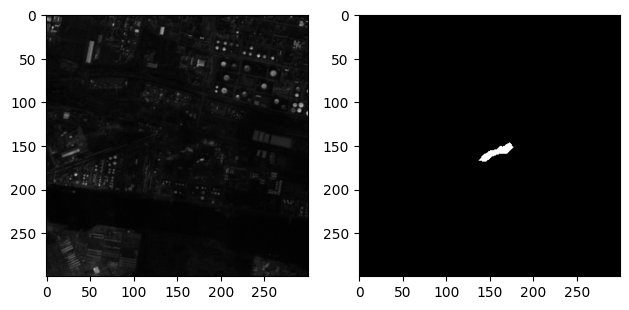

fptdata has shape (300, 300), should be either (120,120) or (300,300).
After cropping


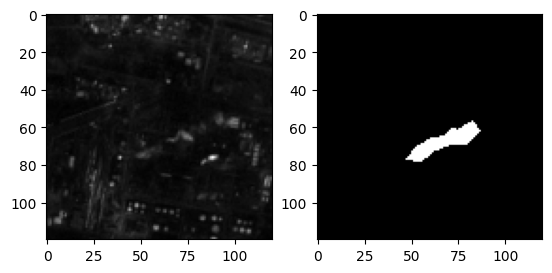

((12, 120, 120), (120, 120))

In [53]:
if 'UCProjectGroup1' in os.getcwd():
    os.chdir('..')
testcase = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif'


def crop_image_and_segmentation(filepath : str, segmentation_path: str, channels: list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]) -> tuple:  
    """_summary_

    Args:
        filepath (str): Path to image geoTIFF
        segmentation_path (str): Path to segmentation geoTIFF
        channels (list, optional): List of indices of bands aka channels to use. Defaults to [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13].

    Returns:
        tuple: Tuple of numpy.ndarrays containing cropped image and segmentation mask respectively in the specified channels.
    """
    imgfile = rio.open(filepath)
    imgdata = np.array([imgfile.read(i) for i in
                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]])
    # imgdata = imgdata[channels] #keep only wanted channels

    seg_file = rio.open(segmentation_path)
    fptdata = seg_file.read() #there is only 1 band for the segmentation masks
    fptdata = fptdata.reshape(fptdata.shape[1:])
    print(f'fptdata has shape {fptdata.shape}, should be either (120,120) or (300,300).')

    size = imgdata.shape[1] #will be 300

    #force square:
    if imgdata.shape[2] != size:
        newimgdata = np.empty((len(channels), size, size))
        newimgdata[:, :, :imgdata.shape[2]] = imgdata[:, :, :imgdata.shape[2]]
        newimgdata[:, :, imgdata.shape[2]:] = imgdata[:,:, imgdata.shape[2] - 1:]
        imgdata = newimgdata

    if size == 300: #300 x 300 images
        fptcropped = fptdata[int((fptdata.shape[0] - 120) / 2):int((fptdata.shape[0] + 120) / 2),
                                int((fptdata.shape[1] - 120) / 2):int((fptdata.shape[1] + 120) / 2)] # crop segmentation data to right size
       
        if np.sum(fptcropped) == np.sum(fptdata): #if we effectively did not do any cropping on the segmentation mask 
            fptdata = fptcropped
            imgdata = imgdata[:, int((imgdata.shape[1] - 120) / 2):int((imgdata.shape[1] + 120) / 2),
                                int((imgdata.shape[2] - 120) / 2):int((imgdata.shape[2] + 120) / 2)] # crop image to central 120x120 pixels 
        else: #if the fptdata was not 120x120 originally, we resize as such
            imgdata = cv2.resize(np.transpose(imgdata, (1, 2, 0)).astype('float32'), (120, 120), #make sure the 300x300 image pixels are the first two dimensions and that bands is the last
                                    interpolation=cv2.INTER_CUBIC)
            imgdata = np.transpose(imgdata, (2, 0, 1)) #tranpose back to bands,pixel,pixel - now (13,120,120)
            fptdata = cv2.resize(fptdata, (120, 120), interpolation=cv2.INTER_CUBIC) #resize 

    return imgdata, fptdata

##code for doing it on all files in the training folder, but for now these are all 120x120
# import glob
# training_path = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\segmentation\training'
# img_paths = sorted(glob.glob(training_path+'\*.img.tif'))
# seg_paths = sorted(glob.glob(training_path + '\*.mask.tif'))

# for i in range(len(img_paths)):
#     imgshape = rio.open(img_paths[i]).read(1).shape[0]
#     segshape = rio.open(seg_paths[i]).read(1).shape[0]
#     if imgshape != 300: 
#         print(imgshape)
#         continue
#     print(f'Found {img_paths[i]} with shape {imgshape} and seg shape {segshape}.')
#     imgtest, segtest = crop_image_and_segmentation(img_paths[i],seg_paths[i])
#     print(f'Cropped: {imgtest.shape}, {segtest.shape}')

##hardcoded, mi scusi
img_path,seg_path = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif', r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\labels\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif'
print(f'TESTING ON: {img_path} AND {seg_path}:')
print(f'Image has shape: {rio.open(img_path).read(1).shape}, {rio.open(seg_path).read().shape}')
fig,(ax1,ax2) = plt.subplots(ncols=2,tight_layout=True)
print('Before cropping')
with rio.open(img_path,'r') as im_src:
    load_data = im_src.read()
    ax1.imshow(load_data[1,:,:],cmap='grey')
with rio.open(seg_path,'r') as seg_src:
    load_data = seg_src.read()
    ax2.imshow(load_data[0,:,:],cmap='grey')
    plt.show()

imgtest, segtest = crop_image_and_segmentation(img_path,seg_path)

fig,(ax1,ax2) = plt.subplots(ncols=2)
print('After cropping')
ax1.imshow(imgtest[1,:,:],cmap='grey')
ax2.imshow(segtest,cmap='grey')
plt.show()

imgtest.shape, segtest.shape

(13, 300, 300)
(13, 300, 300)


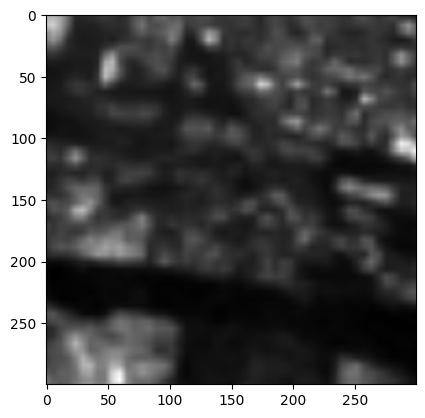

In [22]:
testcase = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif'

with rio.open(testcase, 'r') as src: 
    load_data=src.read()
    plt.imshow(load_data[0,:,:],cmap='grey')
    plt.show()